### Курсовой проект для курса "Python для Data Science"

### Материалы к проекту (файлы):
train.csv, test.csv

### Задание:
Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

### Целевая переменная:
Price

### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям и файлам

In [4]:
TRAIN_DATASET_PATH = 'C://Users//home//Downloads//train.csv'
TEST_DATASET_PATH = 'C://Users//home//Downloads//test.csv'
PREDICTIONS_PATH = 'C://Users//home//Downloads//price.csv' 

### Загрузка данных

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Разбор обучающего датасета

In [6]:
train_df.shape

(10000, 20)

Обучающий датасет имеет 10000 значений и 20 признаков

In [7]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

### Описание датасета :
    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

По полученной информации видим, что признаки LifeSquare и Healthcare_1 имеют пропуски.

### Приведение типов
Приведем к строковому типу признаки Id и DistrictId

In [9]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

### EDA

Построим графики распределение цены

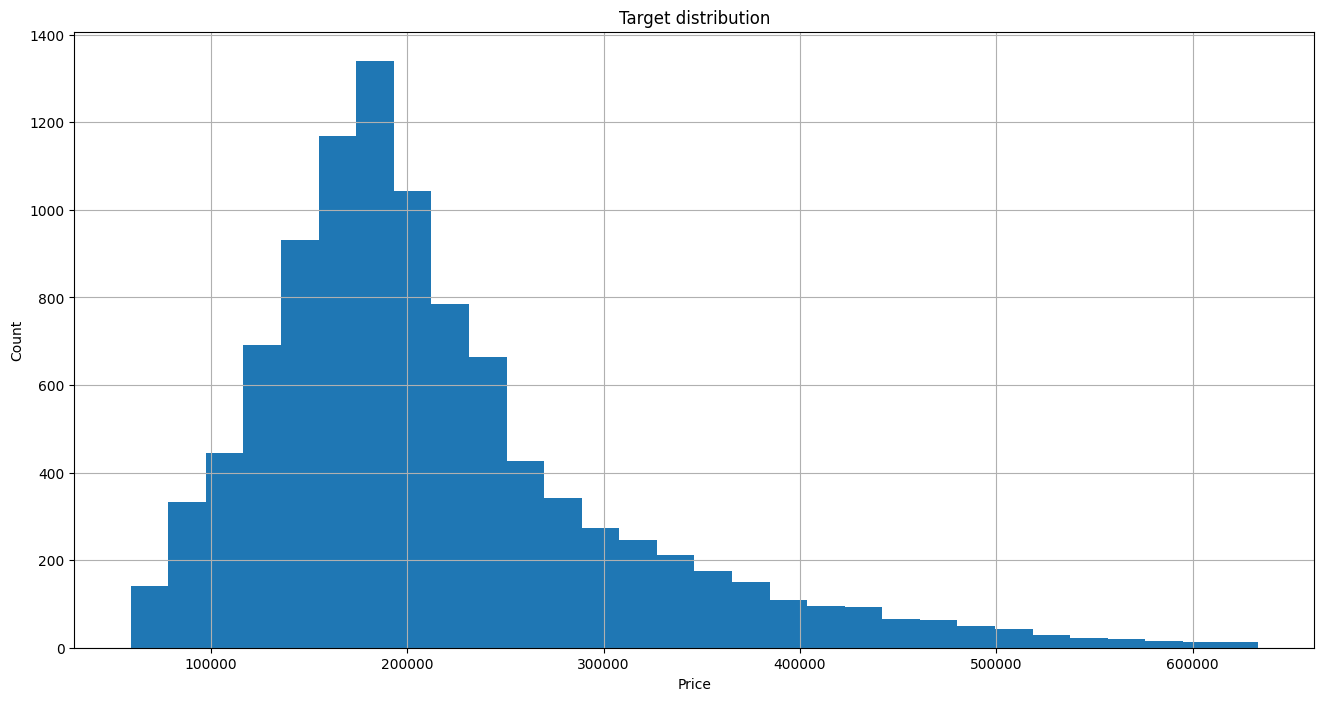

In [10]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Количественные переменные

In [11]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


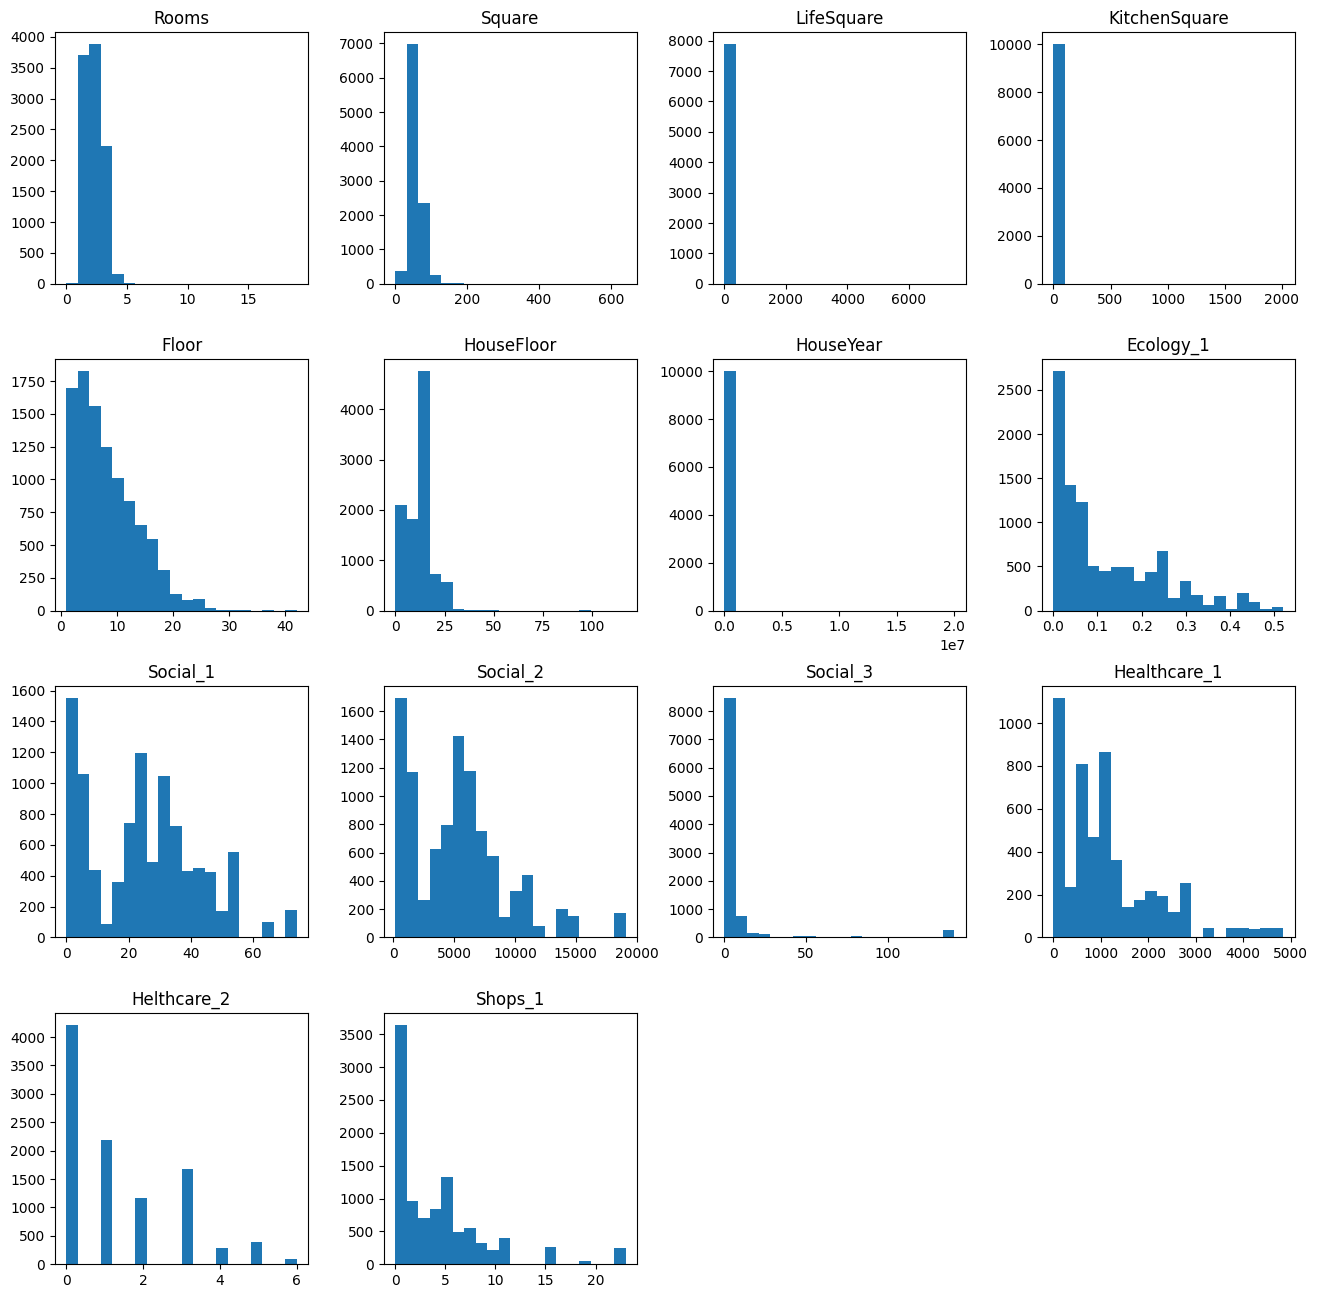

In [12]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features.drop('Price', axis=1, inplace=True)
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

Номинативные переменные

In [13]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [14]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [15]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [16]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [17]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка выбросов

Rooms

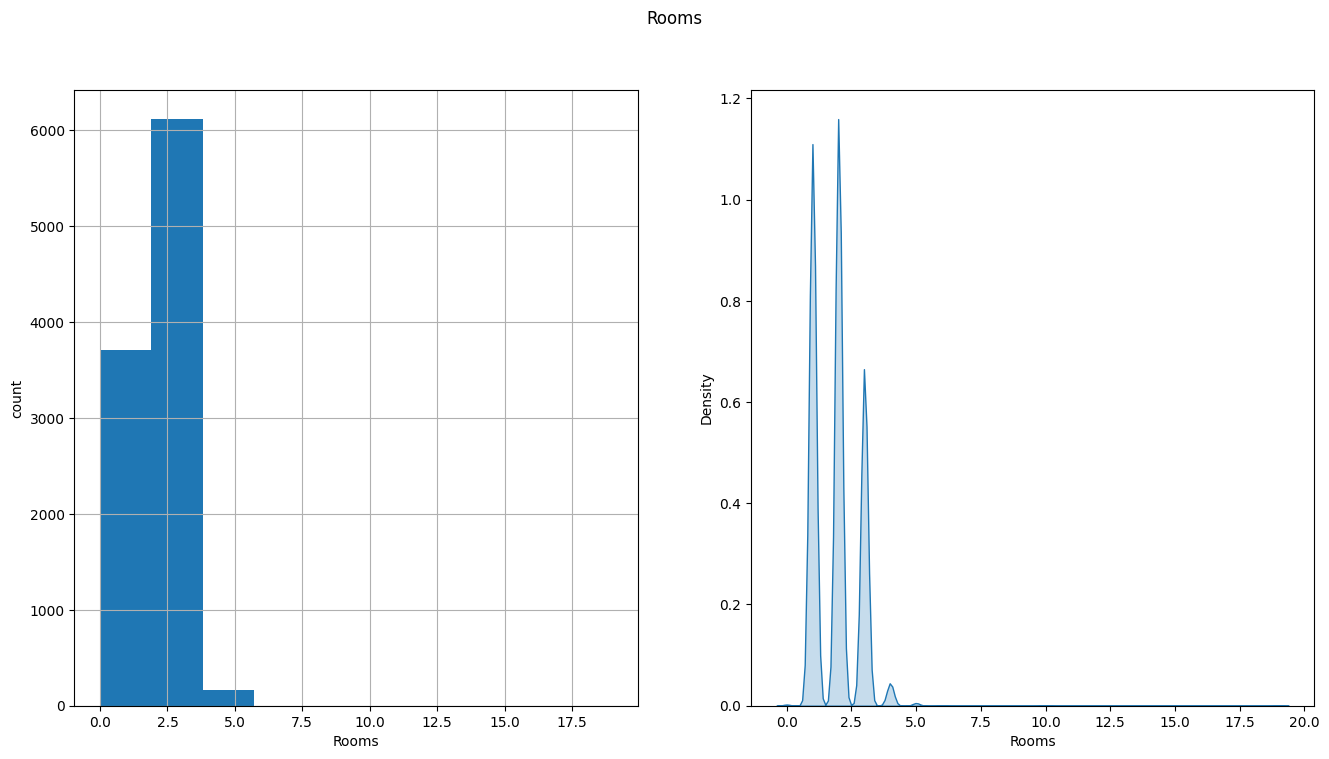

In [18]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Rooms'].hist()
plt.ylabel('count')
plt.xlabel('Rooms')

plt.subplot(122)
sns.kdeplot(train_df['Rooms'], shade=True, legend=False)
plt.xlabel('Rooms')

plt.suptitle('Rooms')
plt.show()

In [19]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [20]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.930730,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531644,0


In [21]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1

Найдем медиану метража 1 комнаты для квартир с 5 и менее комнат. 
Коэфициент =(Общая площадь - Площадь кухни)/Количество комнат.
Затем для квартир в которых комнат больше 6. Берем Площадь вычитаем площадь кухни и делим на коэфициент, 
затем округляем до целого значения и вставляем в тренировочный датасет.

In [22]:
temp_df = train_df.loc[train_df['Rooms'] < 6]
Square_Rooms_K = ((temp_df['Square'] - temp_df['KitchenSquare'])/ temp_df['Rooms']).median()
Square_Rooms_K

27.38544417643741

In [23]:
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = round((train_df['Square'] - train_df['KitchenSquare']) / Square_Rooms_K)
train_df['Rooms'].value_counts()

2.0    3883
1.0    3714
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

Работаем с выбросами признаков "LifeSquare" и "KitchenSquare"

In [24]:
lifesq_med = train_df['LifeSquare'].median()
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_med
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
train_df.loc[train_df['LifeSquare'] > 400, 'LifeSquare'] = lifesq_med

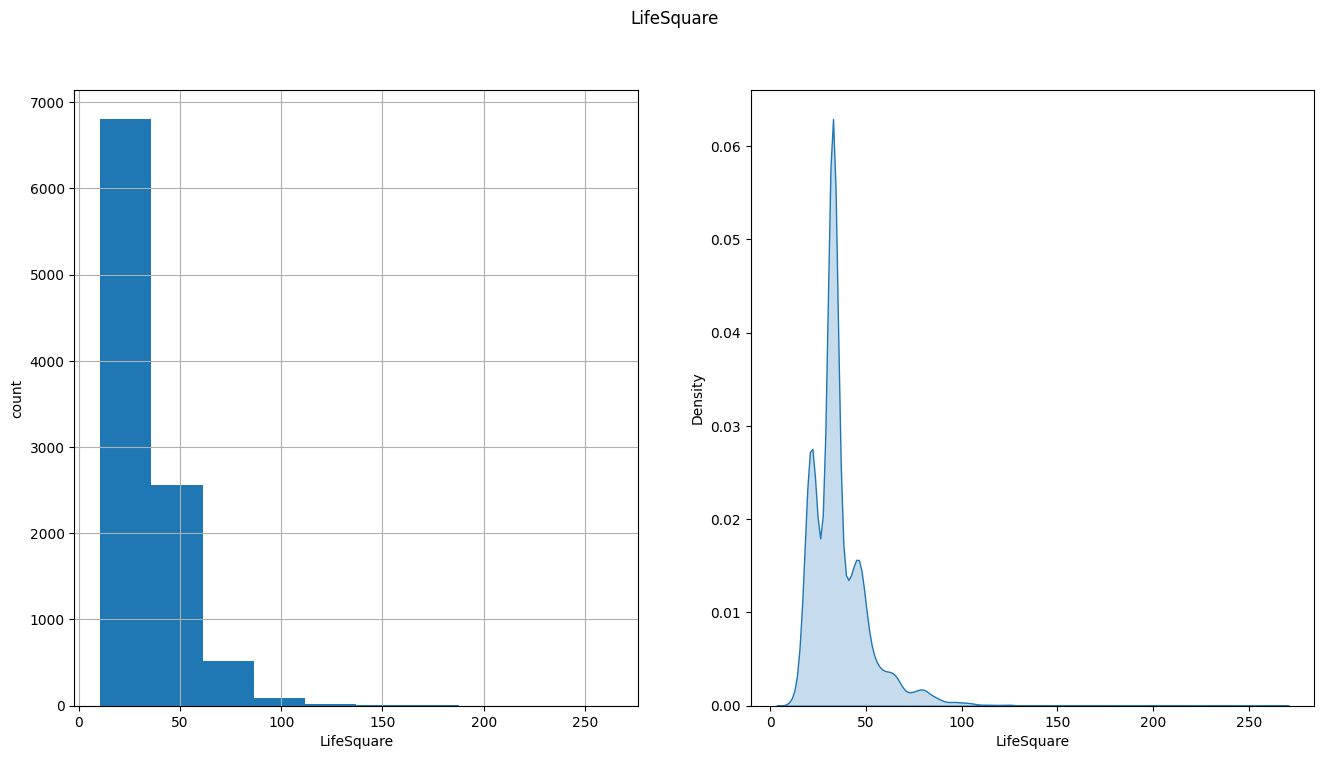

In [25]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['LifeSquare'].hist()
plt.ylabel('count')
plt.xlabel('LifeSquare')

plt.subplot(122)
sns.kdeplot(train_df['LifeSquare'], shade=True, legend=False)
plt.xlabel('LifeSquare')

plt.suptitle('LifeSquare')
plt.show()

In [26]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
32.0         2
41.0         2
51.0         2
30.0         2
112.0        2
37.0         2
43.0         2
25.0         2
58.0         2
84.0         1
75.0         1
21.0         1
54.0         1
62.0         1
40.0         1
29.0         1
1970.0       1
27.0         1
39.0         1
35.0         1
23.0         1
73.0         1
31.0         1
60.0         1
63.0         1
42.0         1
36.0         1
96.0         1
26.0         1
53.0         1
78.0         1
66.0         1
2014.0       1
48.0         1
72.0         1
123.0        1
Name: KitchenSquare, dtype: int64

Найдем коэфициент площади кухни для квартир в которых площадь кухни меньше жилой площади.


In [27]:
temp_df = train_df.loc[train_df['KitchenSquare'] < train_df['Square']]
Square_KitchenSquare_K = (temp_df['Square'] / temp_df['KitchenSquare']).median()
Square_KitchenSquare_K

8.287300054819143

In [28]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))

train_df.loc[condition, 'KitchenSquare'] = round(train_df['Square'] / Square_KitchenSquare_K)

train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1323
5.0     1183
10.0    1090
6.0     1057
9.0      862
7.0      625
12.0     270
11.0     246
13.0      81
4.0       42
14.0      11
15.0      10
16.0       4
17.0       3
23.0       2
22.0       2
21.0       1
33.0       1
18.0       1
20.0       1
19.0       1
24.0       1
Name: KitchenSquare, dtype: int64

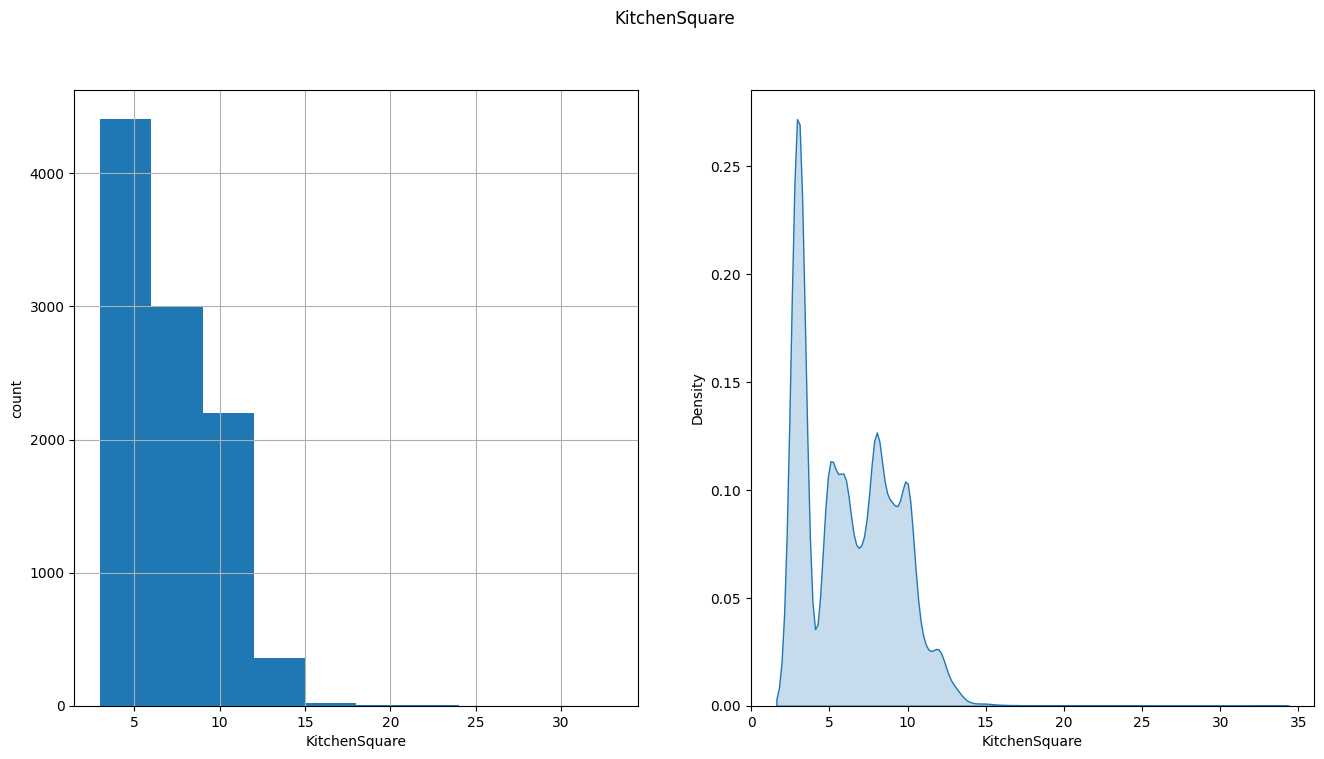

In [29]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['KitchenSquare'].hist()
plt.ylabel('count')
plt.xlabel('KitchenSquare')

plt.subplot(122)
sns.kdeplot(train_df['KitchenSquare'], shade=True, legend=False)
plt.xlabel('KitchenSquare')

plt.suptitle('KitchenSquare')
plt.show()

HouseFloor, Floor

Посмотрим сколько случаев в датасете, когда этаж больше этажности дома

In [30]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

Обработаем данные выбросы:
    соберем индексы строк для этих квартир
    заменим значение выброса на максимальный этаж для соответствующего дома 

In [31]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

train_df.loc[floor_outliers, 'HouseFloor'] = train_df.loc[floor_outliers, 'Floor']

In [32]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

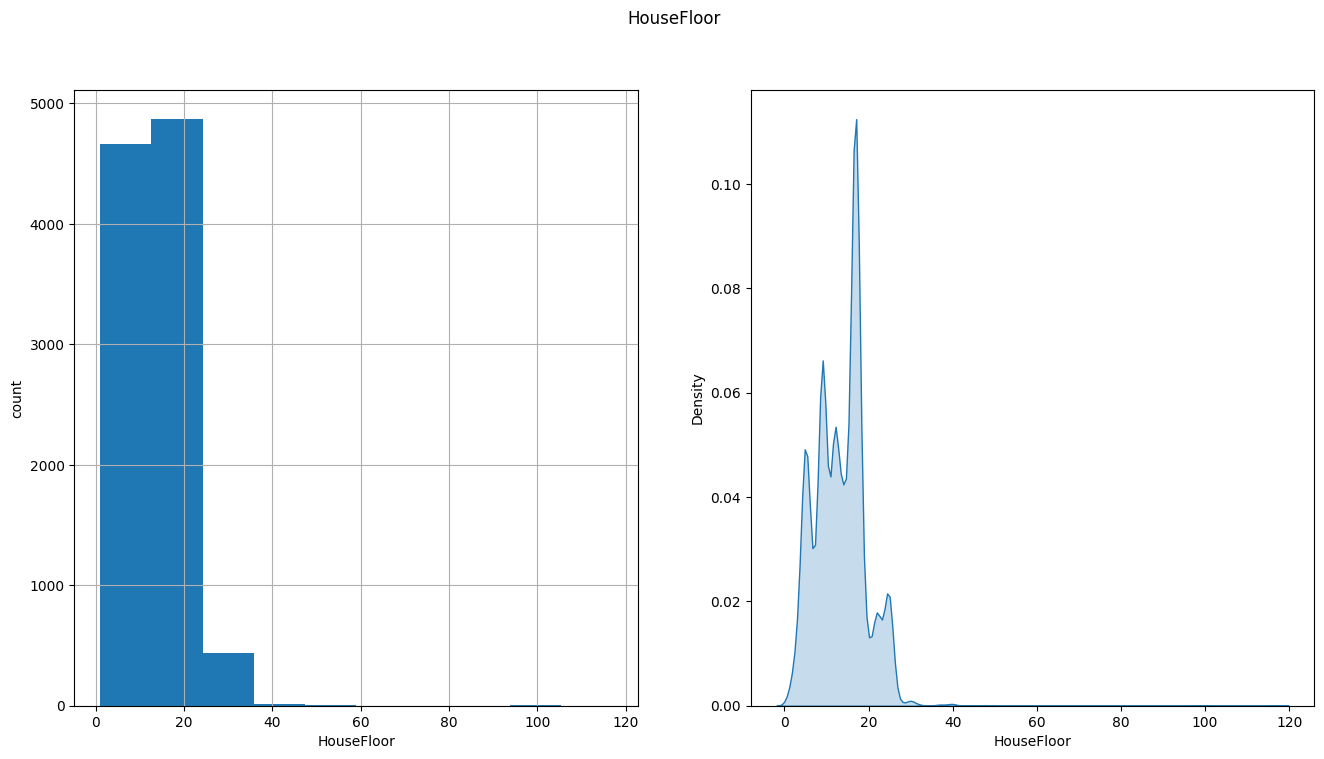

In [33]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['HouseFloor'].hist()
plt.ylabel('count')
plt.xlabel('HouseFloor')

plt.subplot(122)
sns.kdeplot(train_df['HouseFloor'], shade=True, legend=False)
plt.xlabel('HouseFloor')

plt.suptitle('HouseFloor')
plt.show()

HouseYear

In [34]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020
train_df.loc[train_df['HouseYear'] < 1910, 'HouseYear'] = 1910

In [35]:
train_df['HouseYear'].value_counts()

1977    2652
2017     308
2016     305
2015     299
2014     210
        ... 
1914       1
1947       1
1916       1
1910       1
1928       1
Name: HouseYear, Length: 95, dtype: int64

Работаем с выбросами признака "LifeSquare"

In [36]:
train_df['LifeSquare'].fillna((train_df['Square'] - train_df['KitchenSquare']), inplace=True)

Healthcare_1

Превращаем значение данного признака в бинарный набор, где NaN = 0 - нет помощи, значение = 1 - есть помощь.

In [37]:
train_df.describe(include = "all")

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier
count,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000,10000.000000,10000.000000,10000.000000
unique,10000,205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN
top,14038,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN,NaN,NaN
freq,1,851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9175,NaN,NaN,NaN
mean,NaN,NaN,1.887500,56.315775,35.980607,6.323400,8.526700,13.435700,1984.872400,0.118858,...,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,NaN,214138.857399,0.001200,0.182500
std,NaN,NaN,0.811486,21.058732,15.378518,2.916653,5.241148,6.094012,18.416347,0.119025,...,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,NaN,92872.293865,0.034622,0.386275
min,NaN,NaN,1.000000,1.136859,10.523868,3.000000,1.000000,1.000000,1910.000000,0.000000,...,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,NaN,59174.778028,0.000000,0.000000
25%,NaN,NaN,1.000000,41.774881,27.654813,3.000000,4.000000,9.000000,1974.000000,0.017647,...,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,NaN,153872.633942,0.000000,0.000000
50%,NaN,NaN,2.000000,52.513310,32.781260,6.000000,7.000000,14.000000,1977.000000,0.075424,...,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,NaN,192269.644879,0.000000,0.000000
75%,NaN,NaN,2.000000,65.900625,41.415441,9.000000,12.000000,17.000000,2001.000000,0.195781,...,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,NaN,249135.462171,0.000000,0.000000


In [38]:
train_df['Healthcare_1_NaN'] = np.where(train_df['Healthcare_1'].isnull(), 0,1)

In [39]:
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,Healthcare_1_NaN
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,NaN,0,11,B,184966.930730,0,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.450063,0,0,1
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.908524,0,0,1
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.227217,0,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531644,0,0,1
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,...,7715,4,990.0,0,6,B,215898.447742,0,0,1
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,...,4386,14,NaN,1,5,B,296021.204377,0,0,0
7,11993,74,2.0,80.312926,32.781260,3.0,14,14.0,1977,0.075779,...,1437,3,NaN,0,2,B,221244.156664,0,1,0
8,5172,1,2.0,64.511437,32.781260,3.0,9,17.0,1977,0.007122,...,264,0,NaN,0,1,B,229102.795999,0,0,0
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,...,1437,3,NaN,0,2,B,95380.220993,0,0,0


In [40]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
Healthcare_1_NaN         0
dtype: int64

### Построение новых признаков

Преобразуем категориальные признаки "Ecology_2", "Ecology_3", "Shops_2" в бинарные

In [41]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

MedPriceByRoom

In [42]:
med_price_by_room = train_df.groupby(['Rooms'],as_index=False).agg({'Price': 'mean'}).rename(columns={'Price':'MedPriceByRoom'})

med_price_by_room.head()

,Rooms,MedPriceByRoom
0,1.0,159916.281208
1,2.0,215275.231897
2,3.0,289337.962452
3,4.0,383251.100956
4,5.0,410431.605679


In [43]:
med_price_by_room.shape

(5, 2)

In [44]:
train_df = train_df.merge(med_price_by_room, on=['Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,Healthcare_1_NaN,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,MedPriceByRoom
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,11,B,184966.930730,0,0,0,1,1,1,215275.231897
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,16,B,300009.450063,0,0,1,1,1,1,289337.962452
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,3,B,220925.908524,0,0,1,1,1,1,215275.231897
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,5,B,175616.227217,0,0,1,1,1,1,215275.231897
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,4,B,150226.531644,0,0,1,1,1,1,159916.281208


DistrictSize, IsDistrictLarge

In [45]:
district_size = train_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 
                                                                                    'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [46]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,Healthcare_1_NaN,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,MedPriceByRoom,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,184966.930730,0,0,0,1,1,1,215275.231897,22
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,300009.450063,0,0,1,1,1,1,289337.962452,87
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,B,220925.908524,0,0,1,1,1,1,215275.231897,174
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,B,175616.227217,0,0,1,1,1,1,215275.231897,179
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,B,150226.531644,0,0,1,1,1,1,159916.281208,97


In [47]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [48]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Price,Rooms_outlier,HouseFloor_outlier,Healthcare_1_NaN,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,MedPriceByRoom,DistrictSize,IsDistrictLarge
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.887500,56.315775,35.980607,6.323400,8.526700,13.435700,1984.872400,0.118858,24.687000,5352.157400,...,214138.857399,0.001200,0.182500,0.520200,0.990300,0.972500,0.917500,214138.857399,242.306600,0.506900
std,0.811486,21.058732,15.378518,2.916653,5.241148,6.094012,18.416347,0.119025,17.532614,4006.799803,...,92872.293865,0.034622,0.386275,0.499617,0.098015,0.163543,0.275139,53431.700893,268.992652,0.499977
min,1.000000,1.136859,10.523868,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,...,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,159916.281208,1.000000,0.000000
25%,1.000000,41.774881,27.654813,3.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,...,153872.633942,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,159916.281208,55.000000,0.000000
50%,2.000000,52.513310,32.781260,6.000000,7.000000,14.000000,1977.000000,0.075424,25.000000,5285.000000,...,192269.644879,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,215275.231897,104.000000,1.000000
75%,2.000000,65.900625,41.415441,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,...,249135.462171,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,215275.231897,511.000000,1.000000
max,5.000000,641.065193,263.542020,33.000000,42.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,...,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,410431.605679,851.000000,1.000000


Построим Корреляционную матрицу

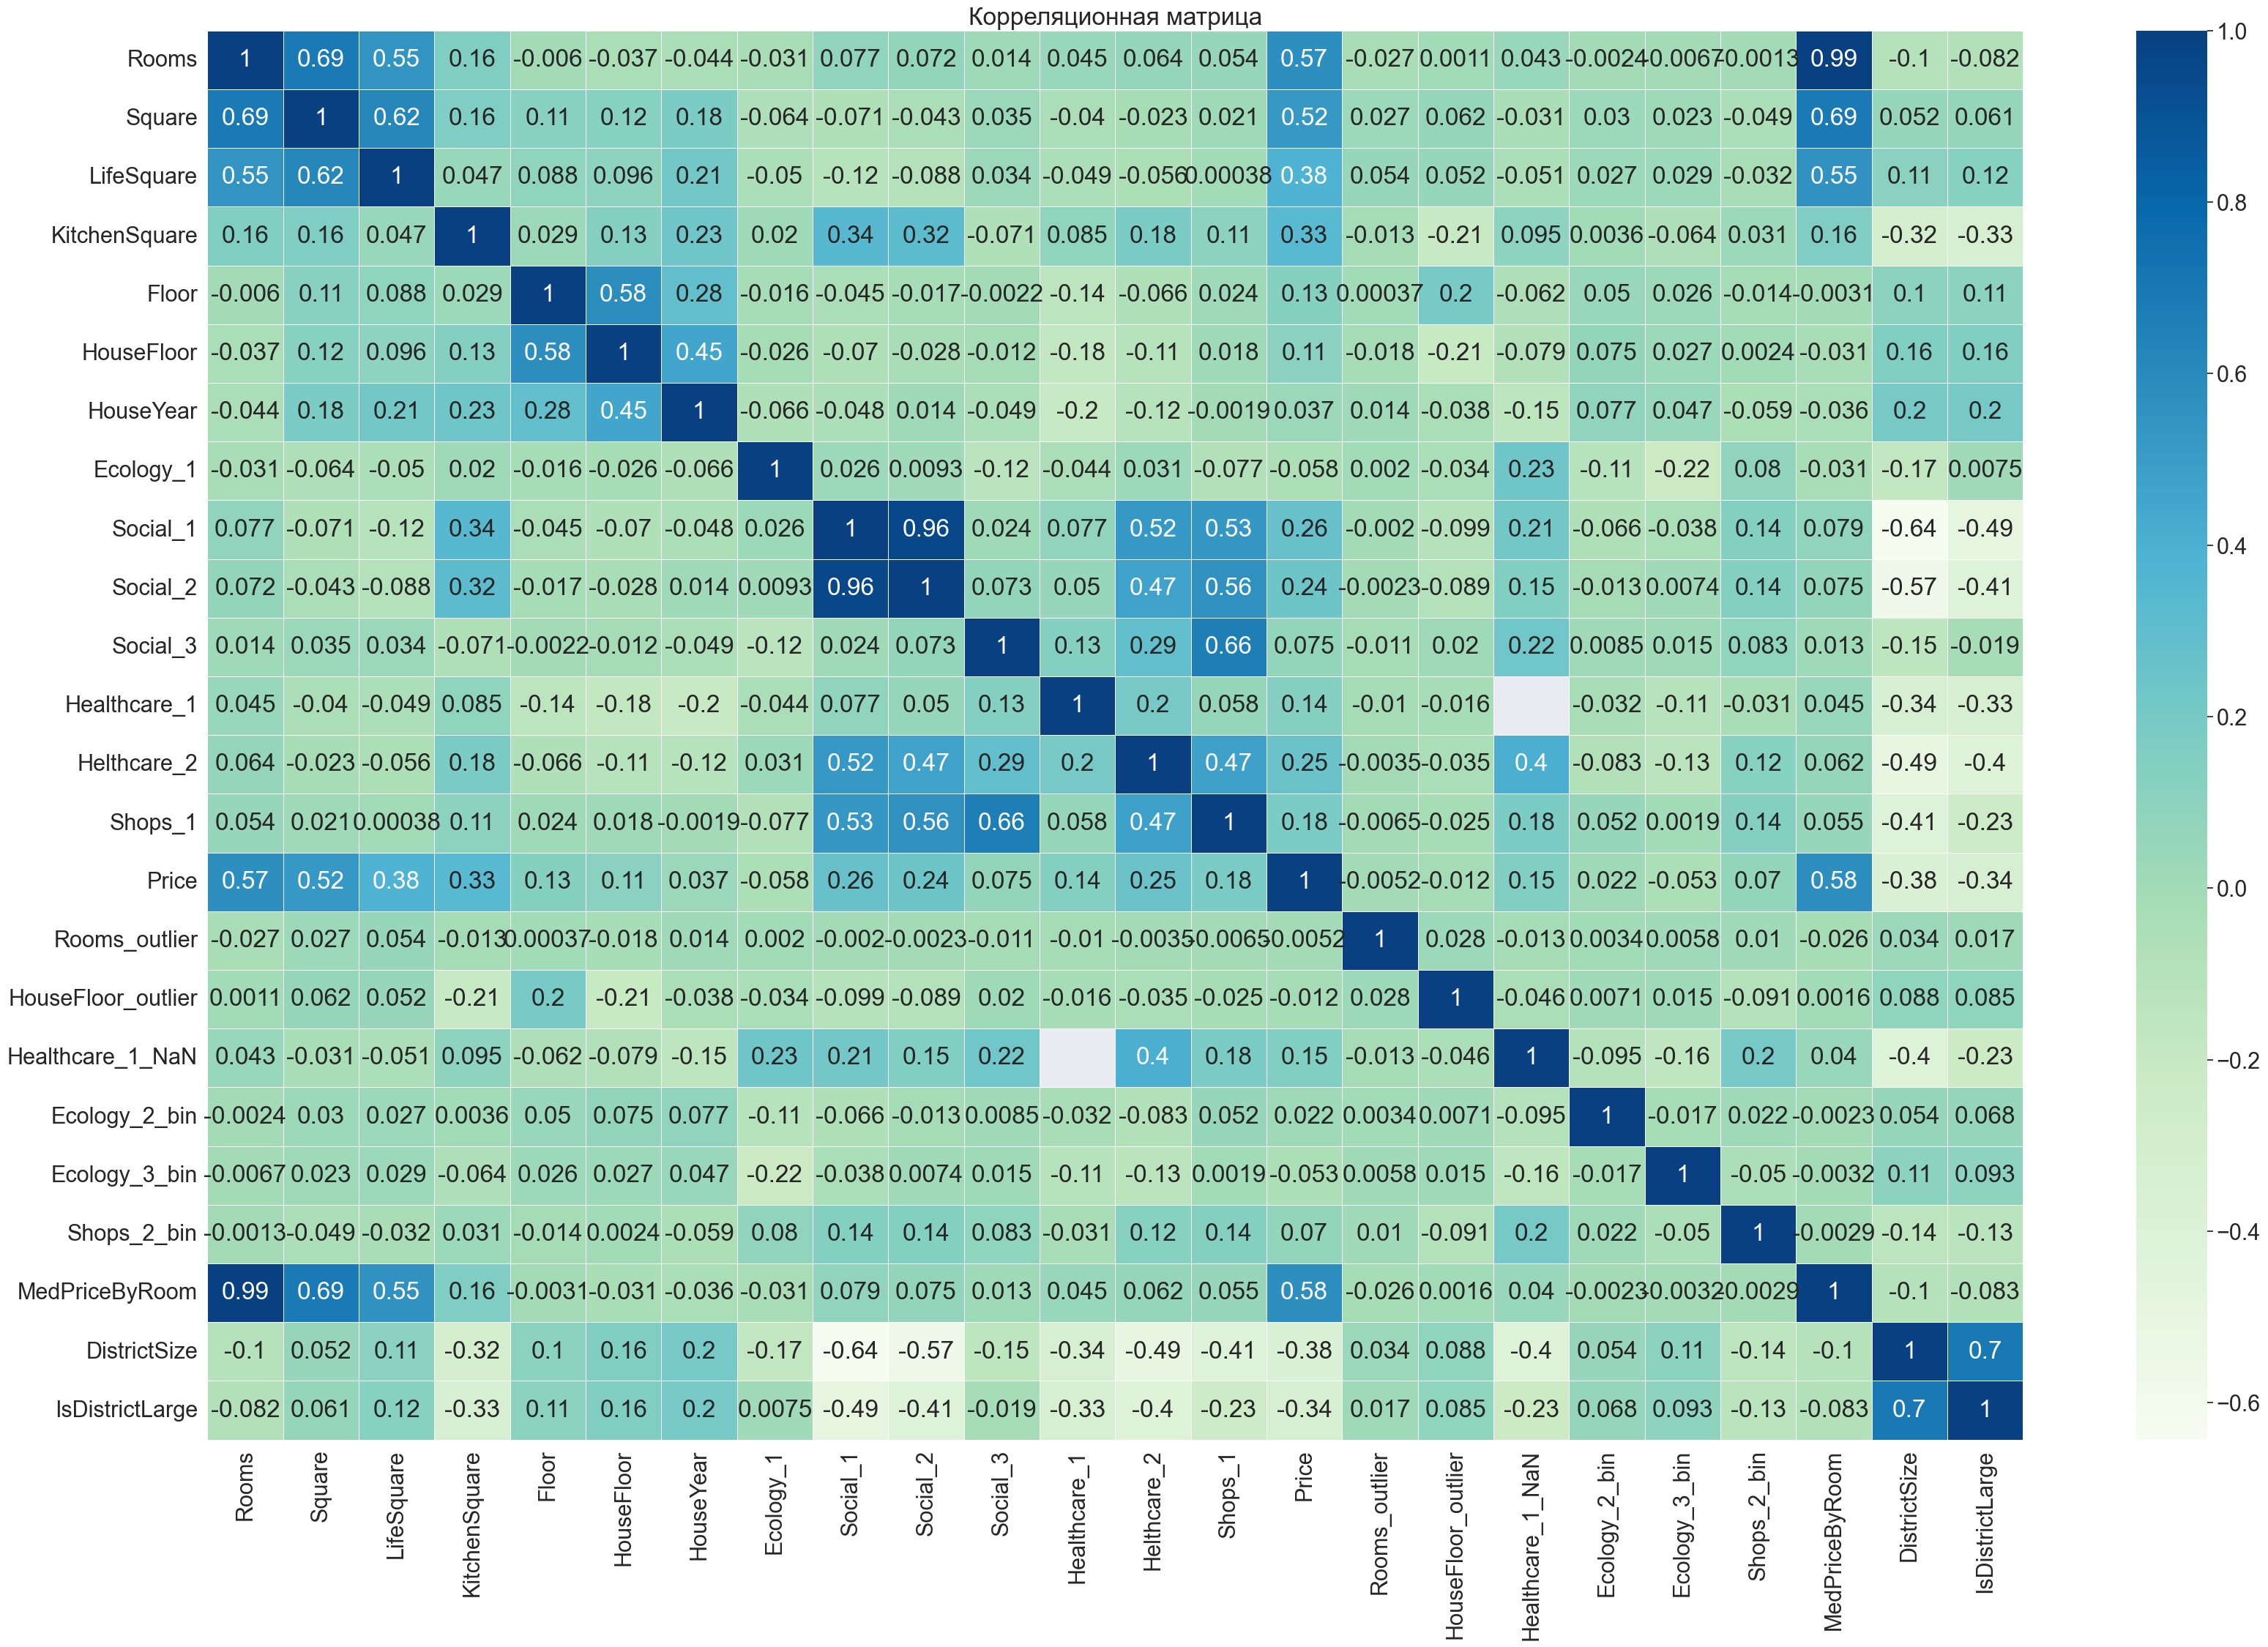

In [49]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Корреляционная матрица')
plt.show()

### Отбираем признаки для модели

In [50]:
feature_names = ['Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_3', 'Healthcare_1_NaN', 'Helthcare_2', 'Shops_1', 
                 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin', 'DistrictSize', 'IsDistrictLarge', 'MedPriceByRoom', 
                 ]
target_name = 'Price'

In [51]:
df = train_df[feature_names + [target_name]]
df.head(10)

,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_3,Healthcare_1_NaN,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByRoom,Price
0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,5,0,0,11,1,1,1,22,0,215275.231897,184966.930730
1,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,1,1,1,16,1,1,1,87,0,289337.962452,300009.450063
2,44.947953,29.197612,3.0,8,12.0,1968,0.049637,34,0,1,1,3,1,1,1,174,1,215275.231897,220925.908524
3,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,3,1,0,5,1,1,1,179,1,215275.231897,175616.227217
4,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,1,1,2,4,1,1,1,97,0,159916.281208,150226.531644
5,80.384479,46.683720,12.0,5,17.0,2011,0.309479,35,4,1,0,6,1,1,1,67,0,289337.962452,215898.447742
6,62.254114,37.160377,7.0,3,5.0,1960,0.460556,20,14,0,1,5,1,1,1,10,0,215275.231897,296021.204377
7,80.312926,32.781260,3.0,14,14.0,1977,0.075779,6,3,0,0,2,1,1,1,114,1,215275.231897,221244.156664
8,64.511437,32.781260,3.0,9,17.0,1977,0.007122,1,0,0,0,1,1,1,1,652,1,215275.231897,229102.795999
9,46.461409,18.915552,8.0,13,17.0,2014,0.075779,6,3,0,0,2,1,1,1,565,1,159916.281208,95380.220993


### Разбиение на train и test

In [52]:
X=pd.DataFrame(df, columns=feature_names)
y=pd.DataFrame(df, columns=['Price'])

In [53]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.67, shuffle=True, random_state=42)

Масштабируем признаки

In [54]:
scaler=StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = feature_names)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns = feature_names)

In [55]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6700 entries, 0 to 6699
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Square            6700 non-null   float64
 1   LifeSquare        6700 non-null   float64
 2   KitchenSquare     6700 non-null   float64
 3   Floor             6700 non-null   float64
 4   HouseFloor        6700 non-null   float64
 5   HouseYear         6700 non-null   float64
 6   Ecology_1         6700 non-null   float64
 7   Social_1          6700 non-null   float64
 8   Social_3          6700 non-null   float64
 9   Healthcare_1_NaN  6700 non-null   float64
 10  Helthcare_2       6700 non-null   float64
 11  Shops_1           6700 non-null   float64
 12  Ecology_2_bin     6700 non-null   float64
 13  Ecology_3_bin     6700 non-null   float64
 14  Shops_2_bin       6700 non-null   float64
 15  DistrictSize      6700 non-null   float64
 16  IsDistrictLarge   6700 non-null   float64


 ### Построение простой модели

In [56]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred=lr.predict(X_valid_scaled)
from sklearn.metrics import r2_score
r2_score(y_valid, y_pred)

0.5333037357195451

### Построение модели

Обучение

In [57]:
rf_model = RandomForestRegressor(n_estimators=500)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

Оценка модели

In [58]:
y_train_preds = rf_model.predict(X_train)
y_valid_preds = rf_model.predict(X_valid)

Train R2:	0.964
Test R2:	0.726


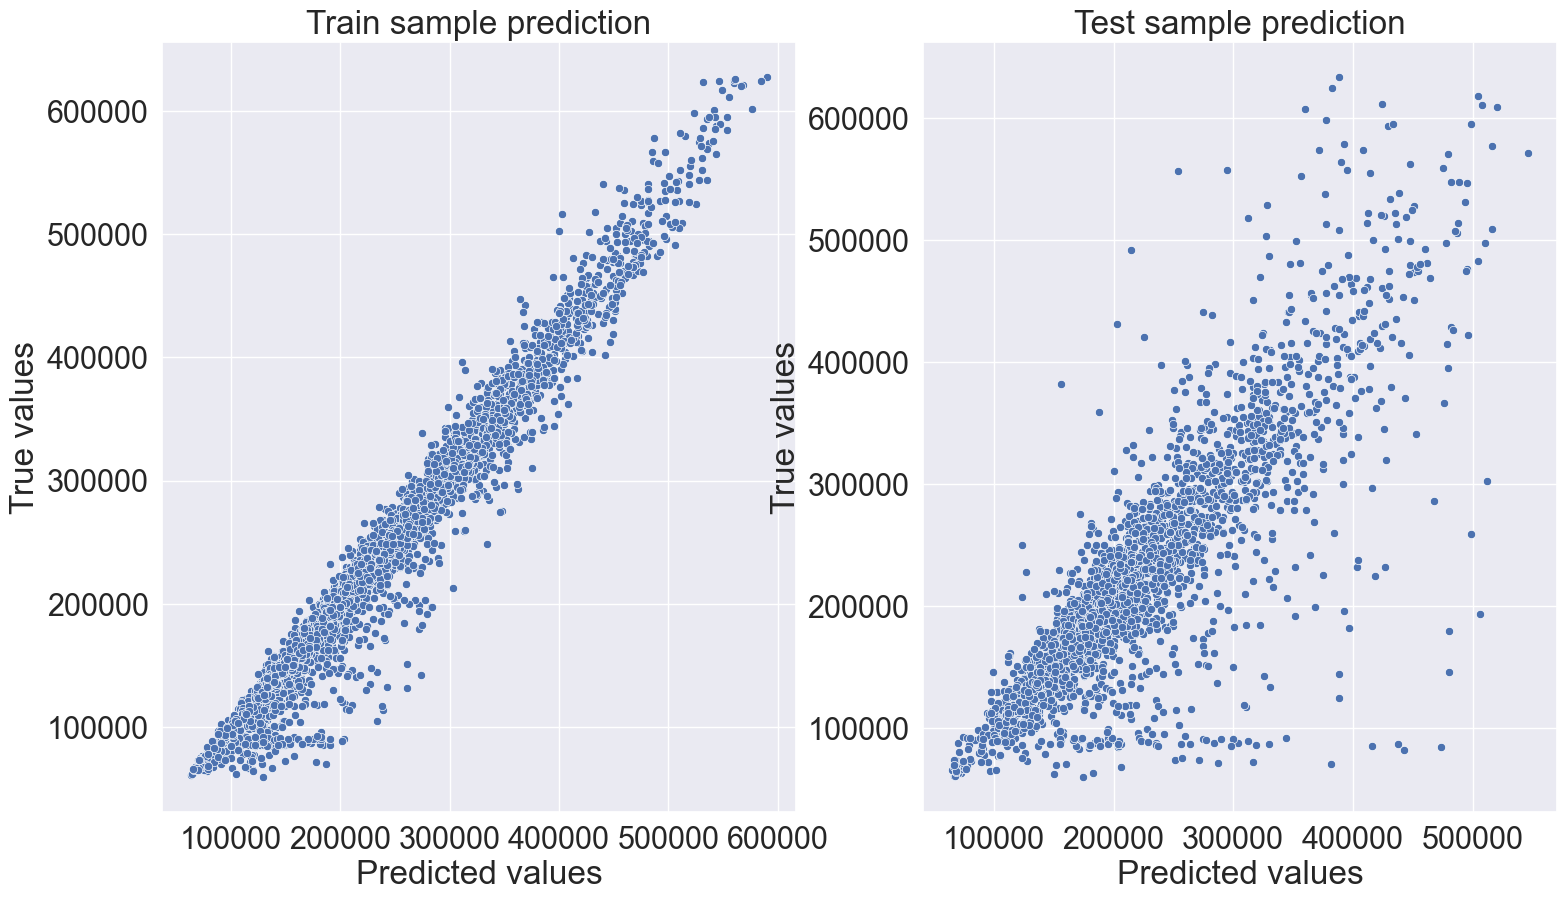

In [59]:
evaluate_preds(y_train['Price'], y_train_preds, y_valid['Price'], y_valid_preds)

### Кросс-валидация

In [60]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=21))
cv_score

array([0.72426491, 0.74748036, 0.70009927, 0.73371092, 0.74243317])

In [61]:
cv_score.mean()

0.7295977261848776

### Важность признаков

In [62]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
0,Square,0.447920
15,DistrictSize,0.238870
8,Social_3,0.052544
6,Ecology_1,0.037782
7,Social_1,0.036838
5,HouseYear,0.036025
1,LifeSquare,0.034766
3,Floor,0.029104
4,HouseFloor,0.024171
2,KitchenSquare,0.021192


### Прогнозирование на тестовом датасете

In [63]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


Смотрим размер датасета

In [64]:
test_df.shape

(5000, 19)

Смотрим информацию датасета

In [65]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Приводим Id и DistrictId к строковому типу

In [66]:
test_df['Id'] = train_df['Id'].astype(str)
test_df['DistrictId'] = train_df['DistrictId'].astype(str)

Смотрим количественные переменные

In [67]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


### Работа с пропусками и выбросами

In [68]:
test_df['Rooms_outlier'] = 0
test_df.loc[(test_df['Rooms'] == 0) | (test_df['Rooms'] >= 6), 'Rooms_outlier'] = 1

test_df.loc[test_df['Rooms'] == 0, 'Rooms'] = 1

temp1_df = test_df.loc[test_df['Rooms'] < 6]
Square_Rooms_K = ((temp1_df['Square'] - temp1_df['KitchenSquare'])/ temp1_df['Rooms']).median()
Square_Rooms_K

test_df.loc[test_df['Rooms'] >= 6, 'Rooms'] = round((test_df['Square'] - test_df['KitchenSquare']) / Square_Rooms_K)

In [69]:
lifesq_med = test_df['LifeSquare'].median()
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_med
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
test_df.loc[test_df['LifeSquare'] > 200, 'LifeSquare'] = lifesq_med

In [70]:
temp1_df = test_df.loc[test_df['KitchenSquare'] < test_df['Square']]
Square_KitchenSquare_K = (temp1_df['Square'] / temp1_df['KitchenSquare']).median()

condition = (test_df['KitchenSquare'].isna()) \
             | (test_df['KitchenSquare'] > test_df['KitchenSquare'].quantile(.975))

test_df.loc[condition, 'KitchenSquare'] = round(test_df['Square'] / Square_KitchenSquare_K)

test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [71]:
test_df['HouseFloor_outlier'] = 0
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
test_df.loc[test_df['Floor'] > test_df['HouseFloor'], 'HouseFloor_outlier'] = 1

floor_outliers = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index
floor_outliers

test_df.loc[floor_outliers, 'HouseFloor'] = test_df.loc[floor_outliers, 'Floor']

In [72]:
test_df.loc[test_df['HouseYear'] > 2020, 'HouseYear'] = 2020
test_df.loc[test_df['HouseYear'] < 1910, 'HouseYear'] = 1910

In [73]:
test_df['LifeSquare'].fillna((test_df['Square'] - test_df['KitchenSquare']), inplace=True)

In [74]:
test_df['Healthcare_1_NaN'] = np.where(test_df['Healthcare_1'].isnull(), 0,1)

In [75]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Rooms_outlier,HouseFloor_outlier,Healthcare_1_NaN
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000
mean,1.907400,56.449500,36.080601,6.294800,8.632000,13.395000,1984.393200,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800,0.00100,0.176800,0.524600
std,0.811269,19.092787,14.699626,2.826781,5.483228,6.231945,18.570718,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365,0.03161,0.381538,0.499444
min,1.000000,1.378543,10.692499,3.000000,1.000000,1.000000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,41.906231,27.990919,3.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000,0.00000,0.000000,0.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,14.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,0.00000,0.000000,1.000000
75%,2.000000,66.285129,41.760597,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000,0.00000,0.000000,1.000000
max,8.000000,223.453689,169.901701,27.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.00000,1.000000,1.000000


### Добовляем новые фичи

In [76]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [77]:
district_size = test_df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 
                                                                                    'DistrictId':'DistrictSize'})

In [78]:
test_df = test_df.merge(district_size, on='DistrictId', how='left')

test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)

In [79]:
test_df['Healthcare_1_NaN'] = np.where(test_df['Healthcare_1'].isnull(), 0,1)

In [80]:
if not 'MedPriceByRoom' in test_df:
    print("merge MedPriceByRoom")
    test_df = test_df.merge(med_price_by_room, on=['Rooms'], how='left')

median_test= train_df['MedPriceByRoom'].median()
test_df['MedPriceByRoom'] = train_df['MedPriceByRoom'].fillna(median_test)
test_df.head()

merge MedPriceByRoom


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_2,Rooms_outlier,HouseFloor_outlier,Healthcare_1_NaN,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByRoom
0,14038,35,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,B,0,0,0,1,1,1,8,0,215275.231897
1,15053,41,2.0,69.263183,32.925087,3.0,6,6.0,1977,0.075779,...,B,0,1,0,1,1,1,39,0,289337.962452
2,4765,53,1.0,13.597819,15.948246,12.0,2,5.0,1910,0.000000,...,B,0,0,1,1,1,1,76,0,215275.231897
3,5809,58,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,B,0,0,0,1,1,1,85,0,215275.231897
4,10783,99,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,...,A,0,0,0,1,1,0,44,0,159916.281208


In [81]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   object 
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        2623 non-null   float64
 16  Helthc

Предсказываем цены для тестового датасета

In [82]:
X_test = test_df[feature_names]

In [83]:
y_test_preds = rf_model.predict(X_test)

In [84]:
y_test_preds

array([205204.01226534, 242605.16591782, 186475.79528586, ...,
       317247.23201388, 337580.66281068, 505942.60107435])

Сохраняем результаты

In [85]:
test_df['Price'] = y_test_preds
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,HouseFloor_outlier,Healthcare_1_NaN,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByRoom,Price
0,14038,35,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,0,0,0,1,1,1,8,0,215275.231897,205204.012265
1,15053,41,2.0,69.263183,32.925087,3.0,6,6.0,1977,0.075779,...,0,1,0,1,1,1,39,0,289337.962452,242605.165918
2,4765,53,1.0,13.597819,15.948246,12.0,2,5.0,1910,0.000000,...,0,0,1,1,1,1,76,0,215275.231897,186475.795286
3,5809,58,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,0,0,0,1,1,1,85,0,215275.231897,344141.005610
4,10783,99,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,...,0,0,0,1,1,0,44,0,159916.281208,146602.421779


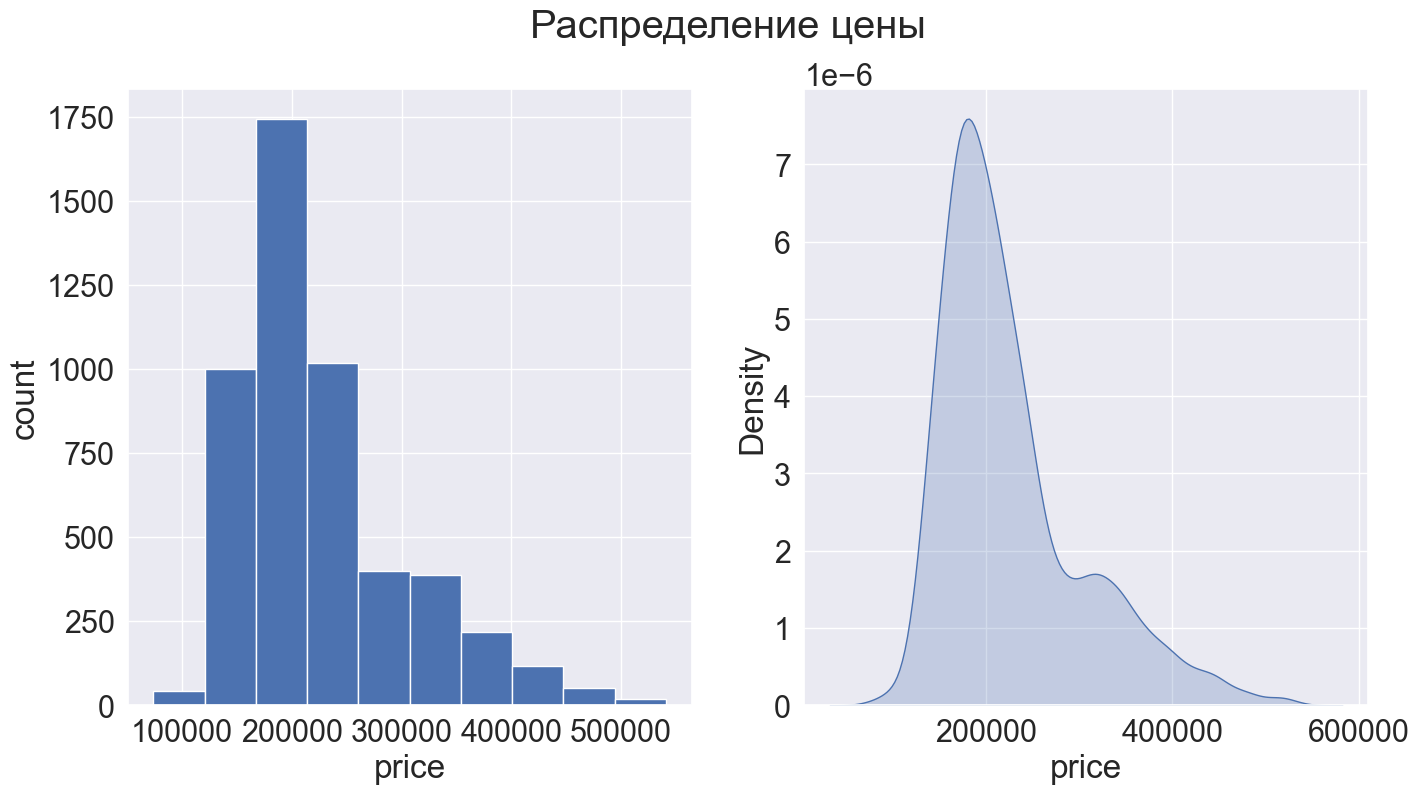

In [86]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
test_df['Price'].hist()
plt.ylabel('count')
plt.xlabel('price')

plt.subplot(122)
sns.kdeplot(test_df['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.suptitle('Распределение цены')
plt.show()

In [87]:
test_df.to_csv(PREDICTIONS_PATH, columns=['Id', 'Price'], index=False, encoding='utf-8')